# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in Grunnill et al. (2024). MetaCast's main feature is broad*CAST*ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a *META*population model.

This notebook uses a disease X SEIHR (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at 10% prevalence: Multinomial seeder
3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.
4. New Vaccine: Multi Dimension/Axis disease X model with flows between some subpopulations.
5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.


# 1. Risk-Structured: Single Dimension/Axis disease X model.

Import MetaCast's main class MetaCaster.

In [1]:
from metacast import MetaCaster

## 1.1 MetaCaster setup
### 1.1.1 Define subpopulation model.

This is the function that is your subpopulation model that MetaCaster will broadcast across the metapopulation generated by your scaffold (see 1.2).
The arguments are required

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time.
    y_deltas : numpy.Array
        The derivatives of y at this time.
    parameters : dict {str:Number or callable}
        A dictionary of parameter values.
    states_index : dict {str:int}

    subpop_suffix : str

    foi : float
        Force of infection experienced be susceptible hosts in this subpopulation.

    Returns
    -------
    y_deltas : numpy.Array
        y_deltas with derivatives of variables in disease X's subpopulation model added to.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-2] += hospitalisation - hospital_recovery
    y_deltas[-1] += hospitalisation

    return y_deltas

### 1.1.2 Define metapopulation scaffold.

In this first we are assuming structure comes from just the risk of hospitalisation (low and high). Simulations are going to be over 90 days. Therefore, we will assume no flows of population between subpopulations. As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our scaffold (a list/tuple of unique strings is also acceptable. **Note** if dealing with a multidimensional metapopulation the scaffold would have to be a list/tuple of sets of strings.

In [3]:
risk_groups = ['low', 'high']

### 1.1.3 Define model attributes

In [4]:
other_model_attributes = {'states': ['S', 'E', 'I', 'H', 'R'],
                          'infected_states': ['E', 'I'],
                          'infectious_states': ['I'],
                          'symptomatic_states': ['I'],
                          'observed_states': ['H','H_cumulative'],
                          'universal_params': ['sigma', 'gamma', 'eta'],
                          'subpop_params': ['p']}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(scaffold=risk_groups, subpop_model=subpop_model, **other_model_attributes)

# 1.2 Running model
## 1.2.1 Setting population

In [6]:
import numpy as np
metapop_model.total_states

12

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.total_states)
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00])

### 1.2.2 Setting up parameters

In [9]:
metapop_model.parameter_names

['beta_[high]',
 'beta_[low]',
 'eta',
 'gamma',
 'p_[high]',
 'p_[low]',
 'rho_[high]_[high]',
 'rho_[high]_[low]',
 'rho_[low]_[high]',
 'rho_[low]_[low]',
 'sigma']

In [10]:
non_subpop_parameters = {'eta': 1/5, 'gamma': 1/7,  'sigma': 1/3}
p_high = 0.3
p_low = 0.01
hospitalisation_probs = {'p_[high]': p_high, 'p_[low]': p_low}
beta = (2/7)/N
beta_parameters = {'beta'+ subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
rho = 1
interaction_parameters = {'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                          for subpop_suffix_i in metapop_model.subpop_suffixes
                          for subpop_suffix_j in metapop_model.subpop_suffixes}
parameters = {**non_subpop_parameters,
              **hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'p_[high]': 0.3,
 'p_[low]': 0.01,
 'beta_[low]': 2.857142857142857e-07,
 'beta_[high]': 2.857142857142857e-07,
 'rho_[low]_[low]': 1,
 'rho_[low]_[high]': 1,
 'rho_[high]_[low]': 1,
 'rho_[high]_[high]': 1}

### 1.2.3 Run metapopulation model

In [11]:
#set time
end_day = 90
time_step = 1
t = np.arange(0, end_day+time_step, time_step)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [12]:
results_1 = metapop_model.integrate(y,t)
results_1

low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

             high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

   observed_states               
                 H H_cumulative  
0         0.000000     0.000000  
1         0.001276     0.001407  
2         0.002509     0.003017  
3         0.003919     0.005066  
4         0.005593     0.007687  
..             ...          ...  
86       18.655788    62.633214  
87       20.301457    68.172298  
88       22.091637    74.199277  
89       24.038897    80.756863  
90       26.156877    87.891455  

[91 rows x 12 columns]

### 1.2.4 Plotting hospitalisations

In [13]:
import seaborn as sns
import pandas as pd

In [14]:
def unstack_results_and_plot_hospitalised(results):
    results_unstacked = results.unstack()
    results_unstacked = results_unstacked.reset_index()
    results_unstacked.columns = ['Subpopulation', 'State','t', 'value']
    hospitalised_results = results_unstacked[results_unstacked['State']=='H']
    sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')
    return results_unstacked

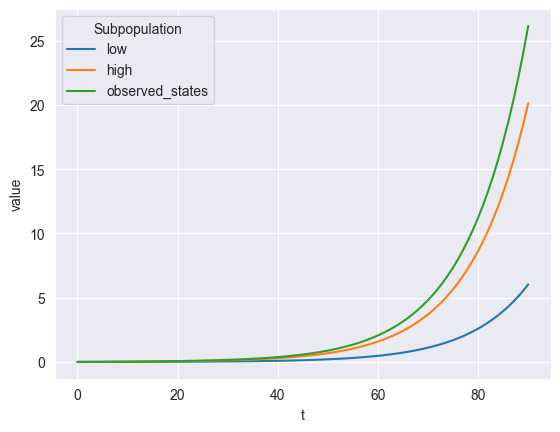

In [15]:
results_1_unstacked = unstack_results_and_plot_hospitalised(results_1)

In [16]:
# Total Hospitalised
display({'Total hospitalisations': results_1.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_1.loc[:,('observed_states','H')])})

{'Total hospitalisations': 87.89145481017233,
 'Peak hospitalisations': 26.15687669462622}

# 2.
## 2.1 Set up Seeders

In [17]:
from metacast import MultnomialSeeder

In [18]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

In [19]:
prevelance = 0.1
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'I': 63062, 'E': 26655, 'H': 283}

In [20]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'I': 6277, 'E': 2762, 'H': 961}

In [21]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [22]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

### 2.3 Run metapopulation model

In [23]:
results_seeded = metapop_model.integrate(y,t)
results_seeded

low                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   794032.457332  32676.313346  63957.663269  313.750061    9019.815992   
2   777950.107544  37096.680089  66327.048240  341.151315   18285.012812   
3   761491.029955  40588.698577  69593.747479  367.300536   27959.223453   
4   744524.668972  43524.208597  73414.831722  393.338589   38142.952120   
..            ...           ...           ...         ...            ...   
86  156864.620524    535.185068   2737.599077   31.692935  739830.902397   
87  156733.510341    494.731038   2532.887573   29.353928  740209.517119   
88  156612.305201    457.339510   2343.355145   27.184133  740559.816012   
89  156500.255982    422.778024   2167.894953   25.171781  740883.899261   
90  156396.670333    390.831847   2005.478148   23.305856  741183.713816   

            high                                                       \
               S            E            I            H             R   
0   90000.000000  2762.000000  6277.000000   961.000000      0.000000   
1   88225.828592  3487.634064  6421.148879  1032.801942    832.586522   
2   86438.900838  4019.341059  6737.994908  1100.940429   1702.822767   
3   84610.114439  4436.402136  7158.080022  1171.276980   2624.126422   
4   82724.963219  4783.391616  7639.805351  1246.521660   3605.318154   
..           ...          ...          ...          ...           ...   
86  17429.402280    59.465008   304.172692   105.639410  82101.320610   
87  17414.834482    54.970115   281.427633    97.843213  82150.924557   
88  17401.367245    50.815501   260.369049    90.610989  82196.837216   
89  17388.917331    46.975336   240.873971    83.903518  82239.329844   
90  17377.407815    43.425761   222.828091    77.684090  82278.654243   

   observed_states                
                 H  H_cumulative  
0      1244.000000      0.000000  
1      1346.552003    361.822200  
2      1442.091744    736.260600  
3      1538.577516   1130.756261  
4      1639.860249   1549.784851  
..             ...           ...  
86      137.332345  31769.583959  
87      127.197141  31785.889041  
88      117.795122  31800.974463  
89      109.075299  31814.930719  
90      100.989946  31827.841697  

[91 rows x 12 columns]

### 2.4 Plotting hospitalisations

,Subpopulation,State,t,value
0,low,S,0,810000.000000
1,low,S,1,794032.457332
2,low,S,2,777950.107544
3,low,S,3,761491.029955
4,low,S,4,744524.668972
...,...,...,...,...
1087,observed_states,H_cumulative,86,31769.583959
1088,observed_states,H_cumulative,87,31785.889041
1089,observed_states,H_cumulative,88,31800.974463
1090,observed_states,H_cumulative,89,31814.930719


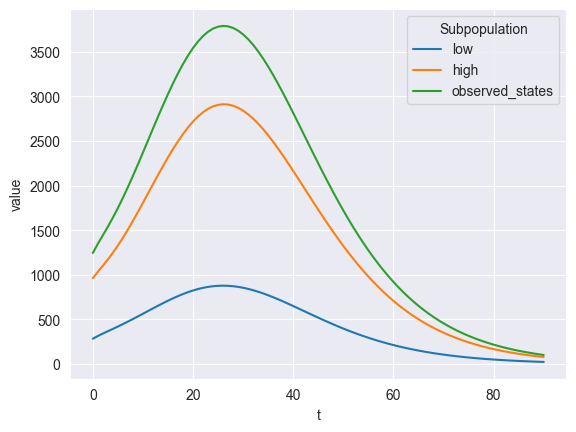

In [24]:
unstack_results_and_plot_hospitalised(results_seeded)

In [25]:
display({'Total hospitalisations': results_seeded.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_seeded.loc[:,('observed_states','H')])})

{'Total hospitalisations': 31827.841696731277,
 'Peak hospitalisations': 3788.607630940858}

# 3. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

## 3.1 Change Population Structure

In [26]:
isolation_groups = ['negative','positive']
rapid_pathogen_test_scaffold = [risk_groups,isolation_groups]

In [27]:
metapop_model.dimensions = rapid_pathogen_test_scaffold
metapop_model.dimensions

[{'high', 'low'}, {'negative', 'positive'}]

## 3.2 Set Population

In [28]:
metapop_model.state_index

{('low', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('low', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('high', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('high', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [29]:
y =np.zeros(metapop_model.total_states)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in metapop_model.state_index[('low', 'negative')].items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in metapop_model.state_index[('high', 'negative')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

## 3.3 Set parameters

In [30]:
metapop_model.parameter_names

['beta_[high,negative]',
 'beta_[high,positive]',
 'beta_[low,negative]',
 'beta_[low,positive]',
 'eta',
 'gamma',
 'p_[high,negative]',
 'p_[high,positive]',
 'p_[low,negative]',
 'p_[low,positive]',
 'rho_[high,negative]_[high,negative]',
 'rho_[high,negative]_[high,positive]',
 'rho_[high,negative]_[low,negative]',
 'rho_[high,negative]_[low,positive]',
 'rho_[high,positive]_[high,negative]',
 'rho_[high,positive]_[high,positive]',
 'rho_[high,positive]_[low,negative]',
 'rho_[high,positive]_[low,positive]',
 'rho_[low,negative]_[high,negative]',
 'rho_[low,negative]_[high,positive]',
 'rho_[low,negative]_[low,negative]',
 'rho_[low,negative]_[low,positive]',
 'rho_[low,positive]_[high,negative]',
 'rho_[low,positive]_[high,positive]',
 'rho_[low,positive]_[low,negative]',
 'rho_[low,positive]_[low,positive]',
 'sigma']

In [31]:
beta_parameters = {'beta' + subpop_suffix: beta for subpop_suffix in metapop_model.subpop_suffixes}
isolation_hospitalisation_probs = {
    **{'p_[high,'+ isolation_group +']': hospitalisation_probs['p_[high]'] for isolation_group in isolation_groups},
    **{'p_[low,'+ isolation_group +']': hospitalisation_probs['p_[low]'] for isolation_group in isolation_groups}
}

In [32]:
transmission_reduction_from_isolation = 0.6
interaction_parameters = {
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',negative]': rho
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups},
    **{'rho'+ subpop_suffix_i+'_['+risk_group +',positive]': rho*(1-transmission_reduction_from_isolation)
       for subpop_suffix_i in metapop_model.subpop_suffixes
       for risk_group in risk_groups}
}
interaction_parameters

{'rho_[low,negative]_[low,negative]': 1,
 'rho_[low,negative]_[high,negative]': 1,
 'rho_[low,positive]_[low,negative]': 1,
 'rho_[low,positive]_[high,negative]': 1,
 'rho_[high,negative]_[low,negative]': 1,
 'rho_[high,negative]_[high,negative]': 1,
 'rho_[high,positive]_[low,negative]': 1,
 'rho_[high,positive]_[high,negative]': 1,
 'rho_[low,negative]_[low,positive]': 0.4,
 'rho_[low,negative]_[high,positive]': 0.4,
 'rho_[low,positive]_[low,positive]': 0.4,
 'rho_[low,positive]_[high,positive]': 0.4,
 'rho_[high,negative]_[low,positive]': 0.4,
 'rho_[high,negative]_[high,positive]': 0.4,
 'rho_[high,positive]_[low,positive]': 0.4,
 'rho_[high,positive]_[high,positive]': 0.4}

In [33]:
parameters = {**non_subpop_parameters,
              **isolation_hospitalisation_probs,
              **beta_parameters,
              **interaction_parameters}
metapop_model.parameters = parameters

## 3.4 Set up Event Que

Import EventQueue and TransferEvent

In [34]:
from metacast.event_handling import EventQueue, TransferEvent

In [35]:
from_index = [index
              for risk_group in risk_groups
              for state, index in metapop_model.state_index[(risk_group,'negative')].items()
              if state in ['E','I']]
to_index = [index
            for risk_group in risk_groups
            for state, index in metapop_model.state_index[(risk_group,'positive')].items()
            if state in ['E','I']]
display(from_index,to_index)

[1, 2, 11, 12]

[6, 7, 16, 17]

In [36]:
test_every_x_days = 7
complaince = 0.8
test_sensitivity = 0.6
rapid_pathogen_test_event = TransferEvent(name='Rapid pathogen test',
                                          times= range(0,end_day+time_step,test_every_x_days),
                                          proportion= test_sensitivity*complaince,
                                          from_index= from_index,
                                          to_index= to_index)


testing_eventqueue = EventQueue(rapid_pathogen_test_event)

## 3.5 Run simulations with Events

In [37]:
results_rapid_test, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                    run_attribute='integrate',
                                                                    parameters=parameters,
                                                                    parameters_attribute='parameters',
                                                                    y0=y,
                                                                    end_time=end_day,
                                                                    start_time=0,
                                                                    simulation_step=time_step)
results_rapid_test

low,negative                                                         \
                S             E             I           H              R   
0   810000.000000  13860.600000  32792.240000  283.000000       0.000000   
1   798598.351805  19627.913990  33698.491676  274.573592    4736.508937   
2   787045.149659  23895.356714  36017.476312  269.868301    9707.989015   
3   775141.595125  27254.490862  39197.302717  269.640012   15072.811285   
4   762777.232464  30055.151518  42901.592796  273.949115   20927.914107   
..            ...           ...           ...         ...            ...   
86  360412.429714    826.099419   1477.338824   17.138013  252912.065113   
87  360098.502878    858.701926   1542.945694   15.987983  253128.932603   
88  359792.292484    875.515023   1607.283492   15.131060  253354.849024   
89  359493.278912    881.452136   1666.444876   14.509621  253589.385539   
90  359201.089158    879.910747   1718.313085   14.072707  253831.685387   

   low,positive                                                         ...  \
              S             E             I           H              R  ...   
0           0.0  12794.400000  30269.760000    0.000000       0.000000  ...   
1           0.0   9167.588209  29606.476159   38.868535    4251.227096  ...   
2           0.0   6568.863982  28077.252226   69.203207    8348.840586  ...   
3           0.0   4706.796704  26067.860480   91.704169   12197.798648  ...   
4           0.0   3372.567193  23836.041128  107.353574   15748.198105  ...   
..          ...           ...           ...         ...            ...  ...   
86          0.0    378.018826   3255.172721   29.683674  280692.053695  ...   
87          0.0    270.862322   2921.296519   28.293017  281134.477059  ...   
88          0.0    194.081334   2603.673037   26.732183  281530.442362  ...   
89          0.0    139.065351   2308.130683   25.057360  281882.675522  ...   
90          0.0     99.644677   2037.456483   23.319929  282194.507827  ...   

   high,negative                           high,positive               \
               I           H             R             S            E   
0    3264.040000  961.000000      0.000000           0.0  1325.760000   
1    3387.942614  915.411714    518.291196           0.0   949.948551   
2    3673.469710  886.405393   1050.210576           0.0   680.667879   
3    4056.485393  875.863729   1612.005909           0.0   487.719846   
4    4497.796594  883.378403   2214.986306           0.0   349.466539   
..           ...         ...           ...           ...          ...   
86    164.148757   57.126683  28611.035550           0.0    42.002092   
87    171.438410   53.293253  28638.837586           0.0    30.095814   
88    178.587054   50.436848  28666.700602           0.0    21.564593   
89    185.160541   48.365387  28694.762626           0.0    15.451706   
90    190.923676   46.909010  28723.092663           0.0    11.071631   

                                          observed_states                
              I           H             R               H  H_cumulative  
0   3012.960000    0.000000      0.000000     1244.000000      0.000000  
1   2960.684550  116.363782    311.723116     1345.217624    360.418724  
2   2816.489675  207.602344    633.960102     1433.079245    726.282536  
3   2620.640821  275.558732    954.800601     1512.766641   1100.658233  
4   2400.097891  323.023593   1266.131978     1587.704685   1485.700233  
..          ...         ...           ...             ...           ...  
86   361.680875   98.941903  30527.449791      202.890274  22833.745583  
87   324.584183   94.306867  30581.087798      191.881121  22862.204558  
88   289.293260   89.104509  30630.112300      181.404601  22889.047824  
89   256.455719   83.522132  30674.645105      171.454500  22914.374856  
90   226.381240   77.731013  30714.890778      162.032658  22938.292898  

[91 rows x 22 columns]

In [38]:
transfer_df

,time,transfered,event
0,0,47402.880000,Rapid pathogen test
1,7,49082.780024,Rapid pathogen test
2,14,48187.544189,Rapid pathogen test
3,21,43645.123015,Rapid pathogen test
4,28,36325.556084,Rapid pathogen test
5,35,28177.311611,Rapid pathogen test
6,42,20739.418243,Rapid pathogen test
7,49,14718.404486,Rapid pathogen test
8,56,10195.945661,Rapid pathogen test
9,63,6954.049696,Rapid pathogen test


### 3.6 Plotting hospitalisations

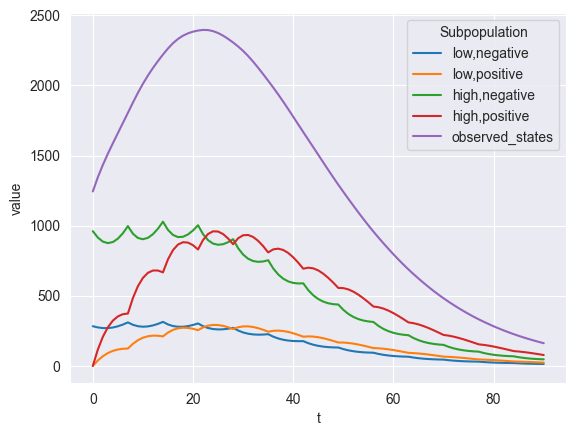

In [39]:
results_rapid_test_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test)

In [40]:
display({'Total hospitalisations': results_rapid_test.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test.loc[:,('observed_states','H')])})

{'Total hospitalisations': 22938.292897748062,
 'Peak hospitalisations': 2396.0371724465435}

## 3.6 Comparing with Rapid test event turned to null (do nothing) event.

In [41]:
metapop_model.state_index

{('low', 'negative'): {'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4},
 ('low', 'positive'): {'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9},
 ('high', 'negative'): {'S': 10, 'E': 11, 'I': 12, 'H': 13, 'R': 14},
 ('high', 'positive'): {'S': 15, 'E': 16, 'I': 17, 'H': 18, 'R': 19},
 'observed_states': {'H': 20, 'H_cumulative': 21}}

In [42]:
rapid_pathogen_test_event.make_event_a_nullevent()
results_rapid_test_null, transfer_df = testing_eventqueue.run_simulation(model_object=metapop_model,
                                                                         run_attribute='integrate',
                                                                         parameters=parameters,
                                                                         parameters_attribute='parameters',
                                                                         y0=y,
                                                                         end_time=end_day,
                                                                         start_time=0,
                                                                         simulation_step=time_step)
results_rapid_test_null

low,negative                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   794032.457332  32676.313346  63957.663269  313.750061    9019.815992   
2   777950.107544  37096.680089  66327.048240  341.151315   18285.012812   
3   761491.029955  40588.698577  69593.747479  367.300536   27959.223453   
4   744524.668972  43524.208597  73414.831722  393.338589   38142.952120   
..            ...           ...           ...         ...            ...   
86  156864.625582    535.185201   2737.599684   31.692941  739830.896592   
87  156733.515348    494.731159   2532.888122   29.353934  740209.511437   
88  156612.310181    457.339624   2343.355662   27.184139  740559.810395   
89  156500.260929    422.778129   2167.895431   25.171786  740883.893725   
90  156396.675249    390.831944   2005.478589   23.305861  741183.708356   

   low,positive                      ... high,negative               \
              S    E    I    H    R  ...             I            H   
0           0.0  0.0  0.0  0.0  0.0  ...   6277.000000   961.000000   
1           0.0  0.0  0.0  0.0  0.0  ...   6421.148879  1032.801942   
2           0.0  0.0  0.0  0.0  0.0  ...   6737.994908  1100.940429   
3           0.0  0.0  0.0  0.0  0.0  ...   7158.080022  1171.276980   
4           0.0  0.0  0.0  0.0  0.0  ...   7639.805351  1246.521660   
..          ...  ...  ...  ...  ...  ...           ...          ...   
86          0.0  0.0  0.0  0.0  0.0  ...    304.172759   105.639432   
87          0.0  0.0  0.0  0.0  0.0  ...    281.427694    97.843234   
88          0.0  0.0  0.0  0.0  0.0  ...    260.369106    90.611008   
89          0.0  0.0  0.0  0.0  0.0  ...    240.874024    83.903536   
90          0.0  0.0  0.0  0.0  0.0  ...    222.828140    77.684107   

                 high,positive                     observed_states  \
               R             S    E    I    H    R               H   
0       0.000000           0.0  0.0  0.0  0.0  0.0     1244.000000   
1     832.586522           0.0  0.0  0.0  0.0  0.0     1346.552003   
2    1702.822767           0.0  0.0  0.0  0.0  0.0     1442.091744   
3    2624.126422           0.0  0.0  0.0  0.0  0.0     1538.577516   
4    3605.318154           0.0  0.0  0.0  0.0  0.0     1639.860249   
..           ...           ...  ...  ...  ...  ...             ...   
86  82101.319944           0.0  0.0  0.0  0.0  0.0      137.332374   
87  82150.923905           0.0  0.0  0.0  0.0  0.0      127.197168   
88  82196.836574           0.0  0.0  0.0  0.0  0.0      117.795147   
89  82239.329211           0.0  0.0  0.0  0.0  0.0      109.075322   
90  82278.653620           0.0  0.0  0.0  0.0  0.0      100.989968   

                  
    H_cumulative  
0       0.000000  
1     361.822200  
2     736.260600  
3    1130.756261  
4    1549.784851  
..           ...  
86  31769.583708  
87  31785.888795  
88  31800.974220  
89  31814.930479  
90  31827.841460  

[91 rows x 22 columns]

In [43]:
transfer_df

,time,transfered,event
0,0,None,Rapid pathogen test
1,7,None,Rapid pathogen test
2,14,None,Rapid pathogen test
3,21,None,Rapid pathogen test
4,28,None,Rapid pathogen test
5,35,None,Rapid pathogen test
6,42,None,Rapid pathogen test
7,49,None,Rapid pathogen test
8,56,None,Rapid pathogen test
9,63,None,Rapid pathogen test


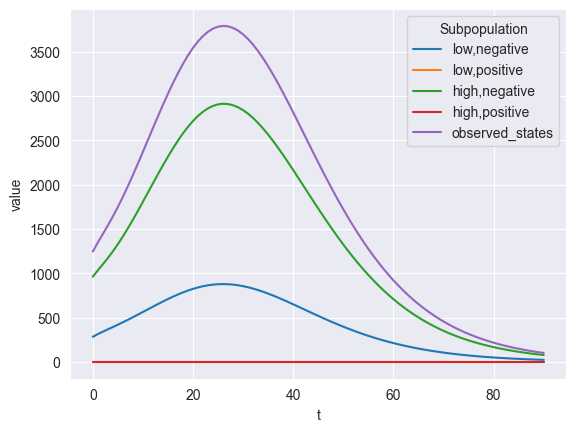

In [44]:
results_rapid_test_null_unstacked = unstack_results_and_plot_hospitalised(results_rapid_test_null)

In [45]:
display({'Total hospitalisations': results_rapid_test_null.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_rapid_test_null.loc[:,('observed_states','H')])})

{'Total hospitalisations': 31827.84146034985,
 'Peak hospitalisations': 3788.607576827358}

# 4. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.

## 4.1 Set metapopulation structure using a list of subpopulation transfer dictionaries for a scaffold.

In [46]:
vaccination_groups = ['unvaccinated','vaccination_lag' 'vaccinated']
vaccination_transfers = [{'from_coordinates': (risk_group,'unvaccinated'),
                          'to_coordinates': (risk_group,'vaccination_lag'),
                          'states': ['S'], 'parameter': 'nu_0'}
                         for risk_group in risk_groups]
vacination_lag_transfers = [{'from_coordinates': (risk_group,'vaccination_lag'),
                             'to_coordinates': (risk_group,'vaccinated'),
                             'states': 'all', 'parameter': 'nu_1'}
                            for risk_group in risk_groups]

vaccination_scaffold = vaccination_transfers + vacination_lag_transfers
vaccination_scaffold

[{'from_coordinates': ('low', 'unvaccinated'),
  'to_coordinates': ('low', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('high', 'unvaccinated'),
  'to_coordinates': ('high', 'vaccination_lag'),
  'states': ['S'],
  'parameter': 'nu_0'},
 {'from_coordinates': ('low', 'vaccination_lag'),
  'to_coordinates': ('low', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'},
 {'from_coordinates': ('high', 'vaccination_lag'),
  'to_coordinates': ('high', 'vaccinated'),
  'states': 'all',
  'parameter': 'nu_1'}]

In [47]:
metapop_model.dimensions = vaccination_scaffold
metapop_model.dimensions

[{'high', 'low'}, {'unvaccinated', 'vaccinated', 'vaccination_lag'}]

## 4.2 Set population

In [48]:
metapop_model.total_states

32

In [49]:
y = np.zeros(metapop_model.total_states)

for state, index in metapop_model.state_index[('high','unvaccinated')].items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

for state, index in metapop_model.state_index[('low','unvaccinated')].items():
    if state in low_risk_state_pops:
        y[index] =low_risk_state_pops[state]

y[-2] += low_risk_state_pops['H'] + high_risk_state_pops['H']
y

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       9.0000e+04, 2.7620e+03, 6.2770e+03, 9.6100e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2440e+03, 0.0000e+00])

## 4.3 Set parameters

In [50]:
metapop_model.parameter_names

['beta_[high,unvaccinated]',
 'beta_[high,vaccinated]',
 'beta_[high,vaccination_lag]',
 'beta_[low,unvaccinated]',
 'beta_[low,vaccinated]',
 'beta_[low,vaccination_lag]',
 'eta',
 'gamma',
 'nu_0',
 'nu_1',
 'p_[high,unvaccinated]',
 'p_[high,vaccinated]',
 'p_[high,vaccination_lag]',
 'p_[low,unvaccinated]',
 'p_[low,vaccinated]',
 'p_[low,vaccination_lag]',
 'rho_[high,unvaccinated]_[high,unvaccinated]',
 'rho_[high,unvaccinated]_[high,vaccinated]',
 'rho_[high,unvaccinated]_[high,vaccination_lag]',
 'rho_[high,unvaccinated]_[low,unvaccinated]',
 'rho_[high,unvaccinated]_[low,vaccinated]',
 'rho_[high,unvaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccinated]_[high,unvaccinated]',
 'rho_[high,vaccinated]_[high,vaccinated]',
 'rho_[high,vaccinated]_[high,vaccination_lag]',
 'rho_[high,vaccinated]_[low,unvaccinated]',
 'rho_[high,vaccinated]_[low,vaccinated]',
 'rho_[high,vaccinated]_[low,vaccination_lag]',
 'rho_[high,vaccination_lag]_[high,unvaccinated]',
 'rho_[high,vaccination

In [51]:
def vaccination_parameters_setup(nu_0,
                                 nu_1,
                                 l_v,
                                 h_v,
                                 other_parameters,
                                 metapop_model):
    parameters = {key: value for key, value in other_parameters.items() if key in metapop_model.parameter_names}
    parameters.update({'nu_0': nu_0,
                       'nu_1': nu_1})

    beta = other_parameters['beta']
    parameters.update({'beta_[high,unvaccinated]': beta,
                       'beta_[high,vaccinated]': beta*(1-l_v),
                       'beta_[high,vaccination_lag]': beta,
                       'beta_[low,unvaccinated]': beta,
                       'beta_[low,vaccinated]': beta*(1-l_v),
                       'beta_[low,vaccination_lag]': beta})

    if h_v < l_v:
        raise ValueError('h_v must be greater than or equal to l_v. ' +
                         'Otherwise vaccine reduced severity given reduced susceptibility is negative.')

    vaccine_reduced_severity_given_reduced_susceptibility = 1-((1-h_v)/(1-l_v))
    p_high = other_parameters['p_[high]']
    p_low = other_parameters['p_[low]']
    parameters.update({'p_[high,unvaccinated]': p_high,
                       'p_[high,vaccinated]': p_high*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[high,vaccination_lag]': p_high,
                       'p_[low,unvaccinated]': p_low,
                       'p_[low,vaccinated]': p_low*(1-vaccine_reduced_severity_given_reduced_susceptibility),
                       'p_[low,vaccination_lag]': p_low})
    rho = other_parameters['rho']
    parameters.update({'rho'+ subpop_suffix_i+subpop_suffix_j: rho
                       for subpop_suffix_i in metapop_model.subpop_suffixes
                       for subpop_suffix_j in metapop_model.subpop_suffixes})
    return parameters

def prob_over_many_days_to_prob_on_a_day(prob, many_days):
    return 1-(1-prob)**(1/many_days)

In [52]:
v_day = end_day
prob_vaccinated_by_v_day = 0.7

prob_vaccinated_per_day = prob_over_many_days_to_prob_on_a_day(prob_vaccinated_by_v_day ,v_day)
vaccination_lag = 1/14
vaccine_reduced_susceptibility = 0.4
vaccine_reduced_severity = 0.8
other_parameters = {'beta':beta, 'rho': rho, **non_subpop_parameters, **hospitalisation_probs}
parameters = vaccination_parameters_setup(nu_0=prob_vaccinated_per_day*complaince,
                                          nu_1=vaccination_lag,
                                          l_v=vaccine_reduced_susceptibility,
                                          h_v=vaccine_reduced_severity,
                                          other_parameters=other_parameters,
                                          metapop_model=metapop_model)
parameters

{'eta': 0.2,
 'gamma': 0.14285714285714285,
 'sigma': 0.3333333333333333,
 'nu_0': 0.010630715875610531,
 'nu_1': 0.07142857142857142,
 'beta_[high,unvaccinated]': 2.857142857142857e-07,
 'beta_[high,vaccinated]': 1.714285714285714e-07,
 'beta_[high,vaccination_lag]': 2.857142857142857e-07,
 'beta_[low,unvaccinated]': 2.857142857142857e-07,
 'beta_[low,vaccinated]': 1.714285714285714e-07,
 'beta_[low,vaccination_lag]': 2.857142857142857e-07,
 'p_[high,unvaccinated]': 0.3,
 'p_[high,vaccinated]': 0.09999999999999998,
 'p_[high,vaccination_lag]': 0.3,
 'p_[low,unvaccinated]': 0.01,
 'p_[low,vaccinated]': 0.0033333333333333327,
 'p_[low,vaccination_lag]': 0.01,
 'rho_[low,vaccinated]_[low,vaccinated]': 1,
 'rho_[low,vaccinated]_[low,unvaccinated]': 1,
 'rho_[low,vaccinated]_[low,vaccination_lag]': 1,
 'rho_[low,vaccinated]_[high,vaccinated]': 1,
 'rho_[low,vaccinated]_[high,unvaccinated]': 1,
 'rho_[low,vaccinated]_[high,vaccination_lag]': 1,
 'rho_[low,unvaccinated]_[low,vaccinated]': 1,

In [53]:
metapop_model.parameters = parameters

### 4.4 Run metapopulation model

In [54]:
results_vaccination = metapop_model.integrate(y,t)
results_vaccination

low,vaccinated                                                  \
                S           E           I         H             R   
0        0.000000    0.000000    0.000000  0.000000      0.000000   
1      294.159756    2.745899    0.372135  0.000075      0.015092   
2     1125.325063   18.914638    5.093183  0.002002      0.424360   
3     2420.536164   55.815377   22.269700  0.012793      2.851870   
4     4111.303523  117.124409   61.288749  0.045637     10.700867   
..            ...         ...         ...       ...           ...   
86  107003.389609  185.803228  932.393981  3.716164  96092.021155   
87  107785.746872  172.449430  868.469412  3.466146  96292.805500   
88  108562.286700  160.013706  808.648294  3.231693  96480.433197   
89  109332.912712  148.436884  752.695086  3.011964  96655.713653   
90  110097.538661  137.663217  700.384803  2.806152  96819.411819   

   low,unvaccinated                                                         \
                  S             E             I           H              R   
0     810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1     785636.035912  32600.470354  63949.302756  313.747122    9019.513020   
2     761584.457782  36821.687079  66267.327644  341.110125   18280.590579   
3     737589.217415  40019.534138  69411.984534  367.116559   27938.656492   
4     713531.305122  42583.030984  73023.164779  392.822352   38082.878418   
..              ...           ...           ...         ...            ...   
86     66927.766065    200.374209   1260.682531   16.039023  614599.647564   
87     66174.328617    182.560412   1152.222783   14.690364  614773.232843   
88     65432.941000    166.314511   1052.921135   13.451954  614931.877126   
89     64703.114869    151.499867    962.023413   12.315156  615076.842740   
90     63984.398617    137.991645    878.835302   11.271962  615209.287977   

    ... high,unvaccinated                            high,vaccination_lag  \
    ...                 I            H             R                    S   
0   ...       6277.000000   961.000000      0.000000             0.000000   
1   ...       6420.219933  1032.792147    832.562327           900.339278   
2   ...       6731.359286  1100.803130   1702.464130          1694.070253   
3   ...       7137.884140  1170.663725   2622.434017          2389.193821   
4   ...       7596.286802  1244.800872   3600.306727          2992.639217   
..  ...               ...          ...           ...                  ...   
86  ...        140.070853    53.459705  68237.177122          1293.312809   
87  ...        128.020434    48.964665  68260.808900          1279.159928   
88  ...        116.987492    44.837060  68282.425471          1265.207076   
89  ...        106.888244    41.048104  68302.194909          1251.447206   
90  ...         97.645553    37.571109  68320.271699          1237.873802   

                                               observed_states                
            E          I         H           R               H  H_cumulative  
0    0.000000   0.000000  0.000000    0.000000     1244.000000      0.000000  
1    8.040826   0.880879  0.009257    0.022859     1346.551627    361.821810  
2   27.855168   5.972588  0.122647    0.320182     1442.081371    736.249504  
3   55.145612  17.269729  0.518338    1.428606     1538.509559   1130.681057  
4   87.301920  35.384024  1.377231    4.001515     1639.611382   1549.499940  
..        ...        ...       ...         ...             ...           ...  
86   2.981681   8.100200  1.920275  113.481309       88.098461  28575.065811  
87   2.717435   7.390775  1.753718  106.758990       80.954829  28584.817744  
88   2.476313   6.742547  1.601343  100.403908       74.374764  28593.761609  
89   2.256320   6.150335  1.461974   94.399017       68.315672  28601.963216  
90   2.055630   5.609386  1.334526   88.727750       62.737944  28609.483142  

[91 rows x 32 columns]

### 4.5 Plotting hospitalisations

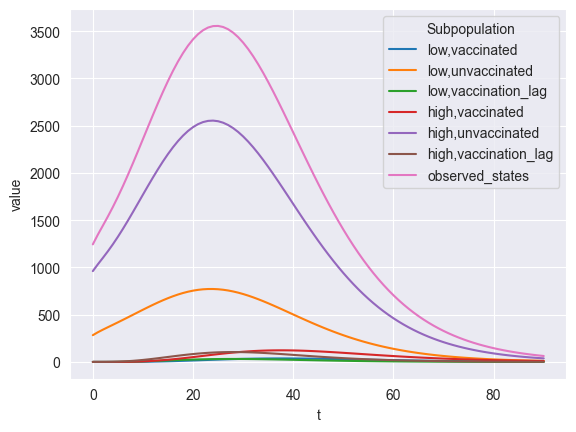

In [55]:
results_vaccination_unstacked = unstack_results_and_plot_hospitalised(results_vaccination)

In [56]:
display({'Total hospitalisations': results_vaccination.loc[90,('observed_states','H_cumulative')],
         'Peak hospitalisations': max(results_vaccination.loc[:,('observed_states','H')])})

{'Total hospitalisations': 28609.48314159786,
 'Peak hospitalisations': 3556.051543125499}

In [57]:
{'Total hospitalisations': 27985.195047851135,
 'Peak hospitalisations': 3500.0847005078635}

{'Total hospitalisations': 27985.195047851135,
 'Peak hospitalisations': 3500.0847005078635}

# 5. New Vaccine's Efficacy is Uncertain: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.

## 5.1 Setup class for running

In [58]:
def vaccination_lhs_sim(sample, metapop_model, t, y0, fixed_parameter):
    parameters = vaccination_parameters_setup(**sample, other_parameters=fixed_parameter,
                                              metapop_model=metapop_model)
    metapop_model.parameters = parameters
    results = metapop_model.integrate(y0, t)
    focused_results = {'Total hospitalisations': results.loc[90, ('observed_states', 'H_cumulative')],
                       'Peak hospitalisations': max(results.loc[:, ('observed_states', 'H')])}
    results_and_sample = sample | focused_results
    return results_and_sample

## 5.2 Setup parameter ranges to sample from.

**Note** currently metacast only support latin hypercube sampling with uniform distributions.

In [59]:
parameter_samples_records = [
    {'parameter': 'nu_0', 'Lower Bound': prob_over_many_days_to_prob_on_a_day(0.5, v_day), 'Upper Bound': prob_over_many_days_to_prob_on_a_day(0.95, v_day)},
    {'parameter': 'nu_1', 'Lower Bound': 1/28, 'Upper Bound': 1/7},
    {'parameter': 'l_v', 'Lower Bound': 0.3, 'Upper Bound': 0.6},
    {'parameter': 'h_v', 'Lower Bound': 0.7, 'Upper Bound': 0.95}
]
parameter_samples_df = pd.DataFrame.from_records(parameter_samples_records)
parameter_samples_df.set_index('parameter',inplace=True)
parameter_samples_df

,Lower Bound,Upper Bound
parameter,,
nu_0,0.007672,0.032738
nu_1,0.035714,0.142857
l_v,0.300000,0.600000
h_v,0.700000,0.950000


##  5.3 Run simulations with LHS

In [60]:
from metacast.sensitivity_analyses import lhs_prcc

In [61]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=10,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)
results_and_sample_df

Simulating LH Sample:   0%|          | 0/10 [00:00<?, ?it/s]

,nu_0,nu_1,l_v,h_v,Total hospitalisations,Peak hospitalisations
0,0.018440,0.074449,0.384686,0.943193,25629.475337,3341.026824
1,0.025585,0.132076,0.525518,0.833839,23743.792638,3149.794740
2,0.022860,0.044918,0.590865,0.797184,27092.295826,3468.946381
3,0.009467,0.105004,0.325793,0.764529,28722.458958,3547.951244
4,0.015372,0.139618,0.419100,0.707493,27274.745562,3416.787667
5,0.015062,0.053841,0.355995,0.742941,28355.019413,3543.744651
6,0.031783,0.097400,0.479591,0.856791,22937.229701,3107.741987
7,0.020978,0.117425,0.423063,0.914627,24279.535508,3203.953153
8,0.030210,0.057495,0.488586,0.887871,24346.821073,3256.854546
9,0.011746,0.086903,0.548401,0.811936,27966.183791,3505.245654


In [62]:
prccs

,n,r,p-val,Number_of_Covariables,lower_CI_0.95,upper_CI_0.95
h_v on Peak hospitalisations,10,-0.783943,0.036954,3,-0.97,-0.08
h_v on Total hospitalisations,10,-0.815996,0.025195,3,-0.97,-0.16
l_v on Peak hospitalisations,10,-0.029143,0.950547,3,-0.77,0.74
l_v on Total hospitalisations,10,-0.271262,0.556245,3,-0.85,0.61
nu_0 on Peak hospitalisations,10,-0.946505,0.001235,3,-0.99,-0.67
nu_0 on Total hospitalisations,10,-0.948268,0.001137,3,-0.99,-0.68
nu_1 on Peak hospitalisations,10,-0.901513,0.005541,3,-0.99,-0.46
nu_1 on Total hospitalisations,10,-0.852784,0.014730,3,-0.98,-0.28


##  5.4 Run simulations with LHS in parallell

In [63]:
import os
number_cpu = os.cpu_count()
number_cpu

20

In [64]:
# setup the dask cluster
import dask

client = dask.distributed.Client(n_workers=number_cpu-1, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 19
Total threads: 19,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54076,Workers: 19
Dashboard: http://127.0.0.1:8787/status,Total threads: 19
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:54199,Total threads: 1
Dashboard: http://127.0.0.1:54206/status,Memory: 845.72 MiB
Nanny: tcp://127.0.0.1:54079,


In [65]:
results_and_sample_df, prccs = lhs_prcc(parameters_df=parameter_samples_df,
                                        sample_size=1000,
                                        model_run_method=vaccination_lhs_sim,
                                        metapop_model=metapop_model,
                                        client= client,
                                        t=t,
                                        y0=y,
                                        fixed_parameter=other_parameters)

In [66]:
client.close()

In [67]:
prccs

,n,r,p-val,Number_of_Covariables,lower_CI_0.95,upper_CI_0.95
h_v on Peak hospitalisations,1000,-0.775296,8.946478e-201,3,-0.80,-0.75
h_v on Total hospitalisations,1000,-0.830697,2.485705e-255,3,-0.85,-0.81
l_v on Peak hospitalisations,1000,0.078587,1.305987e-02,3,0.02,0.14
l_v on Total hospitalisations,1000,-0.040389,2.025888e-01,3,-0.10,0.02
nu_0 on Peak hospitalisations,1000,-0.964557,0.000000e+00,3,-0.97,-0.96
nu_0 on Total hospitalisations,1000,-0.968952,0.000000e+00,3,-0.97,-0.96
nu_1 on Peak hospitalisations,1000,-0.910522,0.000000e+00,3,-0.92,-0.90
nu_1 on Total hospitalisations,1000,-0.867357,8.608824e-304,3,-0.88,-0.85
